Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Assay information
Experimental determination of lipophillicity is most commonly carried out using a "shake flask" method where the analyte of interest is dissolved in a bi-phasic mixture of two immiscible liquids and after the system reaches equilibrium the concentrations of the analyte are measured in each phase. Then, the logarithm of the ratio of is taken. The most common solvent system is Octanol/Water which has become the standard experimental measure of lipophilicity in the medicinal chemistry space often called the partition coefficient, Poct/w . Explanation and image from [here](http://lokeylab.wikidot.com/shake-flask-logk).

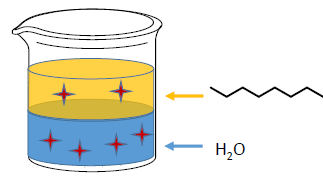

## Description of readout:
- **LOGD_74**: Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301363/

In [86]:
%load_ext autoreload
%autoreload 2

import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

# For downloading ChEMBL datasets
from chembl_webresource_client.new_client import new_client as client
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [87]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [88]:
# load data
data = pd.read_parquet('gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301363_raw.parquet')
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14759005,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
1,None,None,14759006,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
2,None,None,14759007,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
3,None,None,14759008,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
4,None,None,14759009,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,None,None,14770246,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4196,None,None,14770247,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4197,None,None,14770248,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4198,None,None,14770249,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [89]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "LOGD_74",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,LOGD_74
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,1.80
1,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,1.80
2,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,1.81
3,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,1.81
4,CCOC(=O)c1coc2ccccc2c1=O,1.81
...,...,...
4195,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,1.80
4196,COc1ccc(C(C)NC(=O)C2(N)CCN(c3ncnc4[nH]ccc34)CC...,1.80
4197,COc1cc(OC2CCNCC2)ccc1Nc1ncc(Cl)c(-c2cnc3ccccn2...,1.80
4198,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...,1.80


In [90]:
# Define data column names
endpoints = [
    'LOGD_74',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [91]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data.dropna(subset=endpoints),
    data_cols=data_cols,
    data_types=["continuous"],
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True,
)
data_look = curator()

2024-04-09 13:32:06.462 | WARNING  | polaris.curation._data_curator:check_outliers:191 - Detected 3 outliers for data column LOGD_74 using zscore. Please revise the data and consider remove the outliers. 


data_col: LOGD_74


/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mol_ids = data.query(f"`{data_col}_stereo_cliff`==True & (`{UNDEF_ED}` | `{UNDEF_EZ}`) ")[


2024-04-09 13:32:06.610 | WARNING  | polaris.curation.readouts:detailed_distributions_plots:456 - Threshold not available for readout 'LOGD_74'


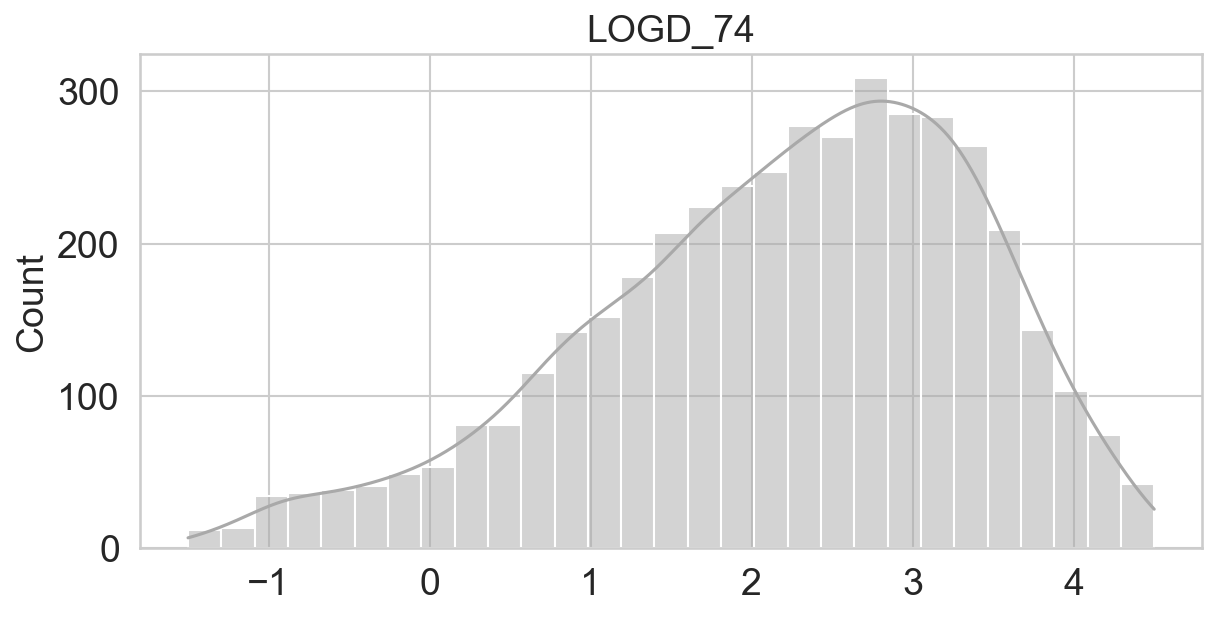

In [92]:
# Distribution plot of all related readouts
from polaris.curation.readouts import detailed_distributions_plots

fig = detailed_distributions_plots(df=data_look[["LOGD_74"]])

The curation detected 3 outliers in the data. Let's take a look at the distribution.

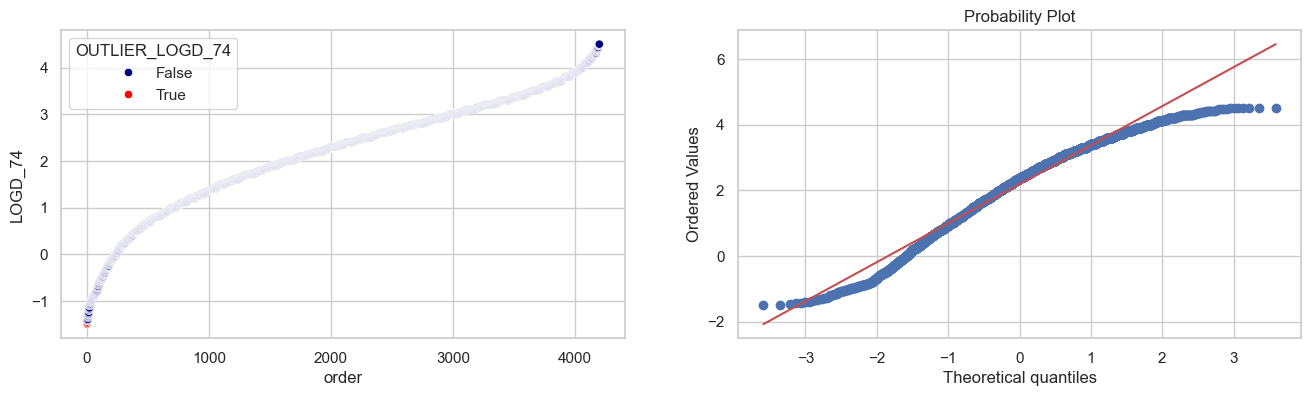

In [93]:
visualize_distribution(dataset=data_look, data_cols=data_cols);

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [94]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

LOGD_74_stereo_cliff    2
dtype: object

In [95]:
data_look.query("LOGD_74_stereo_cliff ==True").sort_values("molhash_id_no_stereo")

,SMILES,LOGD_74,ORIGINAL_LOGD_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_LOGD_74,LOGD_74_zscore,LOGD_74_stereo_cliff
253,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,2.03,2.03,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,de5315fb3792a8ccc347e3b70146c225e38852cb,22dc262e7e401f7c5c91b2218ce537783d7fd2c4,1,0,1,2,1,False,False,False,-0.271441,True
2294,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,3.58,3.58,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,dd43a535c6ad8a7aa556705928eeb0661aee1eaa,22dc262e7e401f7c5c91b2218ce537783d7fd2c4,1,0,1,2,1,False,False,False,1.003511,True


One pair of stereoisomers shows activity shifts in the dataset based on Zscore.

2024-04-09 13:32:07.124 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:60 - Verify the stereo ismomers for readout `LOGD_74`
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/viz_utils.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  legends = to_plot[fig_cols].apply(lambda x: "\n".join([f"{fig_col}: {x[i]}" for i, fig_col in enumerate(fig_cols)]), axis=1).tolist()


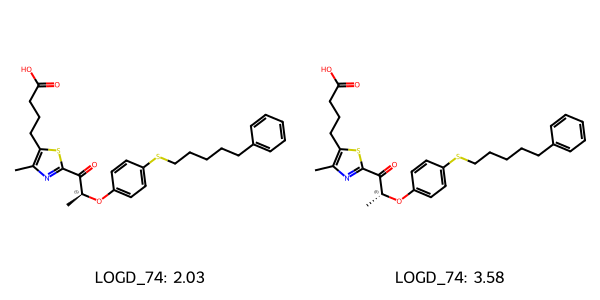

In [96]:
from polaris.curation.viz_utils import verify_stereoisomers
figs = verify_stereoisomers(data_cols=["LOGD_74"], dataset=data_look, mol_col=mol_col)
figs[0]

Typically, logD > 3.5 is considered having highly lipophilicy and poor solubility. The logD normally shouldn't be influenced by their stereochemistry. The difference might be caused by the experimental noise. 

### Re-run curation, removing molecules as needed

In [97]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=False,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f'size before curation: {len(data)}')
data_curated = curator_with_stereo()
print(f'size after curation: {len(data_curated)}')

size before curation: 4200


2024-04-09 13:32:11.476 | WARNING  | polaris.curation._data_curator:run_data_curation:224 - Data types are not provides. We will try our best to determine the types
2024-04-09 13:32:11.478 | WARNING  | polaris.curation._data_curator:check_outliers:191 - Detected 3 outliers for data column LOGD_74 using zscore. Please revise the data and consider remove the outliers. 


data_col: LOGD_74
size after curation: 4198


/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mol_ids = data.query(f"`{data_col}_stereo_cliff`==True & (`{UNDEF_ED}` | `{UNDEF_EZ}`) ")[


In [98]:
# Drop molecules with stereo activity cliff
data_curated= data_curated.drop(data_curated[~data_curated["LOGD_74_stereo_cliff"].isna()].index)
data_curated

,SMILES,LOGD_74,ORIGINAL_LOGD_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_LOGD_74,LOGD_74_zscore,LOGD_74_stereo_cliff
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,2.01,2.01,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,0007d9df4656b011caf3afc146b6b8fe44a8ea89,b8954faa941a4059fe1fba124a72ed36e95c7760,3,0,3,8,1,False,False,False,-0.286148,NaN
1,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,1.42,1.42,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,00134f769eb1a70818787bb15017c37d6cccf15d,daa9c2c86fbd71109aa6cd9dd9f333532b0c678e,5,1,4,32,2,False,False,False,-0.768511,NaN
2,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,4.20,4.20,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,0013b7daa7c92ed4adadeb46442b933c4c2f9718,bca4dc09156f36c5c03781a0451d69054eb57e76,1,1,0,2,2,True,False,False,1.504319,NaN
3,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,1.40,1.40,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,001ebcfbf1492c715075be2e3e8440a8f1961ae2,109dc7a7720a57255d15140982c56bb253838da5,2,0,2,4,1,False,False,False,-0.784862,NaN
4,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,3.69,3.69,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,1.087361,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,3.20,3.20,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,ffb833f42c9d470a03cbea466fa2c7496f348eb4,70cf3d8997770c88ed01cc1c7b9488d78427bdee,0,0,0,1,1,False,True,False,0.686754,NaN
4194,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,1.06,1.06,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,ffc6547fe2c544895720224fd9e3c4a180ca4358,768cc67e1873c49209443cec3699f97b256a629a,1,0,1,2,1,False,False,False,-1.062834,NaN
4195,Nc1ccc(OCc2ccccc2)cc1,2.20,2.20,Nc1ccc(OCc2ccccc2)cc1,Nc1ccc(OCc2ccccc2)cc1,ffcbb6581f6a80c8ecf8ef96108696dcc5824839,a82a1d8b3bdd4fb5ade3d6701c6ccad9cfacb46b,0,0,0,1,1,False,True,False,-0.130810,NaN
4196,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,2.55,2.55,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,ffdb52ce9d95429e689a69ccd9a356007f0479dc,41b81806179f3ca3fb16699efe0929a620912060,0,0,0,1,1,False,True,False,0.155337,NaN


In [105]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'LOGD_74': ColumnAnnotation(description="Octan-1-ol/water (pH7.4) distribution coefficent.",
                                            user_attributes={"PH": "7.4",
                                                }
                                ),
}

In [100]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_LogD_74",
    description="Octan-1-ol/water (pH7.4) distribution coefficent experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301363/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2016"},
)

In [101]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpa46opx1k/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpa46opx1k/dataset/dataset.json']

In [102]:
# data_curated.to_parquet(f'./data/CHEMBL3301363_curated.parquet') # Save just in case. Requires a data folder.
data_curated.to_parquet(f"gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301363_curated.parquet")

In [103]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [104]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)